<a href="https://colab.research.google.com/github/Soobian/deeplearning-project-f1/blob/main/deep_learning_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Getting the dataset

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomZoom, RandomBrightness, BatchNormalization
from tensorflow.keras import mixed_precision
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive


## Import base models



In [ ]:
from tensorflow.keras.applications import (
    EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3,
    EfficientNetB4, EfficientNetB5, EfficientNetB6, EfficientNetB7
)

models_dict = {
    "EfficientNetB0": (EfficientNetB0, (224, 224)),
    "EfficientNetB1": (EfficientNetB1, (240, 240)),
    "EfficientNetB2": (EfficientNetB2, (260, 260)),
    "EfficientNetB3": (EfficientNetB3, (300, 300)),
    "EfficientNetB4": (EfficientNetB4, (380, 380)),
    "EfficientNetB5": (EfficientNetB5, (456, 456)),
    "EfficientNetB6": (EfficientNetB6, (528, 528)),
    "EfficientNetB7": (EfficientNetB7, (600, 600)),
}


## Mount Google Drive

In [ ]:
# Path of datasets
train_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/train'
val_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/val'
test_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/test'
autosport_dataset_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Autosport_Dataset'

In [ ]:
# Connect to Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data preparation for each model

In [ ]:
# Function to prepare data
def prepare_data(input_size, dataset_mix_percentage):
    # Training data
    train_data = keras.utils.image_dataset_from_directory(
        train_dir,
        labels="inferred",
        label_mode="categorical",
        color_mode="rgb",
        batch_size=32,
        image_size=(input_size[0], input_size[1]),
    )

    # Validation data
    val_data = keras.utils.image_dataset_from_directory(
        val_dir,
        labels="inferred",
        label_mode="categorical",
        color_mode="rgb",
        batch_size=32,
        image_size=(input_size[0], input_size[1]),
        shuffle=False
    )

    # Test data
    test_data = keras.utils.image_dataset_from_directory(
        test_dir,
        labels="inferred",
        label_mode="categorical",
        color_mode="rgb",
        batch_size=32,
        image_size=(input_size[0], input_size[1]),
        shuffle=False
    )

    # Autosport data
    autosport_data = keras.utils.image_dataset_from_directory(
        autosport_dataset_dir,
        labels="inferred",
        label_mode="categorical",
        color_mode="rgb",
        batch_size=32,
        image_size=(input_size[0], input_size[1]),
        shuffle=True
    )

    # Calculate the number of samples to take from each dataset
    autosport_mix_percentage = 1 - dataset_mix_percentage
    num_train_samples = tf.data.experimental.cardinality(train_data).numpy()
    num_val_samples = tf.data.experimental.cardinality(val_data).numpy()

    num_train_dataset_samples = int(num_train_samples * dataset_mix_percentage)
    num_train_autosport_samples = int(num_train_samples * autosport_mix_percentage)

    num_val_dataset_samples = int(num_val_samples * dataset_mix_percentage)
    num_val_autosport_samples = int(num_val_samples * autosport_mix_percentage)

    # Split autosport_data for mixing
    autosport_train_data = autosport_data.take(num_train_autosport_samples)
    autosport_val_data = autosport_data.skip(num_train_autosport_samples).take(num_val_autosport_samples)

    # Mix training data
    train_data_mixed = (
        train_data.take(num_train_dataset_samples)
        .concatenate(autosport_train_data)
    )

    # Mix validation data
    val_data_mixed = (
        val_data.take(num_val_dataset_samples)
        .concatenate(autosport_val_data)
    )

    # Shuffle the mixed datasets
    train_data_mixed = train_data_mixed.shuffle(buffer_size=1000)
    val_data_mixed = val_data_mixed.shuffle(buffer_size=1000)

    # Prefetch to optimize performance
    train_data_mixed = train_data_mixed.prefetch(tf.data.AUTOTUNE)
    val_data_mixed = val_data_mixed.prefetch(tf.data.AUTOTUNE)
    test_data = test_data.prefetch(tf.data.AUTOTUNE)

    return train_data_mixed, val_data_mixed, test_data

In [ ]:
data_dict = {}
for model_name, model_info in models_dict.items():
    print(f"Preparing data for {model_name} with input size {model_info[1]}")
    train_data, val_data, test_data = prepare_data(model_info[1], 0.7)
    data_dict[model_name] = {
        "train_data": train_data,
        "val_data": val_data,
        "test_data": test_data,
    }

    print(f"Data prepared for {model_name}.")

Preparing data for EfficientNetB0 with input size (224, 224)
Found 6616 files belonging to 10 classes.
Found 2909 files belonging to 10 classes.
Found 1462 files belonging to 10 classes.
Found 1196 files belonging to 10 classes.
Data prepared for EfficientNetB0.
Preparing data for EfficientNetB1 with input size (240, 240)
Found 6616 files belonging to 10 classes.
Found 2909 files belonging to 10 classes.
Found 1462 files belonging to 10 classes.
Found 1196 files belonging to 10 classes.
Data prepared for EfficientNetB1.
Preparing data for EfficientNetB2 with input size (260, 260)
Found 6616 files belonging to 10 classes.
Found 2909 files belonging to 10 classes.
Found 1462 files belonging to 10 classes.
Found 1196 files belonging to 10 classes.
Data prepared for EfficientNetB2.
Preparing data for EfficientNetB3 with input size (300, 300)
Found 6616 files belonging to 10 classes.
Found 2909 files belonging to 10 classes.
Found 1462 files belonging to 10 classes.
Found 1196 files belongi

### Real-world footage

In [ ]:
# Load the full dataset
autosport_dataset = keras.utils.image_dataset_from_directory(
    autosport_dataset_dir,
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(input_size_mn2[1], input_size_mn2[0]),
    shuffle=True  # Shuffle to ensure random splitting
)

# Get the class names from the full dataset
class_names = autosport_dataset.class_names

# Determine the size of the dataset
dataset_size = len(autosport_dataset)

# Set the split ratio (e.g., 80% for training, 20% for validation)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size

# Split the dataset into training and validation sets
autosport_train_data = autosport_dataset.take(train_size)
autosport_val_data = autosport_dataset.skip(train_size).take(val_size)

# Prefetch to optimize performance
autosport_train_data = autosport_train_data.prefetch(tf.data.AUTOTUNE)
autosport_val_data = autosport_val_data.prefetch(tf.data.AUTOTUNE)


Found 839 files belonging to 10 classes.


### Mix the video game and real-life footage

In [ ]:
# Define the mixing percentages
dataset_mix_percentage = 0.7
autosport_mix_percentage = 1 - dataset_mix_percentage

# Get the number of training and validation samples
num_train_samples = tf.data.experimental.cardinality(train_data).numpy()
num_val_samples = tf.data.experimental.cardinality(val_data).numpy()

# Calculate the number of samples to take from each dataset
num_train_dataset_samples = int(num_train_samples * dataset_mix_percentage)
num_train_autosport_samples = int(num_train_samples * autosport_mix_percentage)

num_val_dataset_samples = int(num_val_samples * dataset_mix_percentage)
num_val_autosport_samples = int(num_val_samples * autosport_mix_percentage)

# Mix training data
train_data_mixed = (
    train_data.take(num_train_dataset_samples)
    .concatenate(autosport_train_data.take(num_train_autosport_samples))
)

# Mix validation data
val_data_mixed = (
    val_data.take(num_val_dataset_samples)
    .concatenate(autosport_val_data.take(num_val_autosport_samples))
)

# Prefetch mixed datasets to optimize performance
train_data_mixed = train_data_mixed.prefetch(tf.data.AUTOTUNE)
val_data_mixed = val_data_mixed.prefetch(tf.data.AUTOTUNE)


## Add augmentation to dataset

In [ ]:
# Add randomization to dataset
data_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.3),
        RandomZoom(0.1),
        RandomContrast(0.3),
        RandomBrightness(0.1),
    ]
)

# Show dataset examples

In [ ]:
# Show image from dataset classes
plt.figure(figsize=(10, 10))
for images, labels in train_data_mixed.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        pred_class = np.argmax(labels[i])
        plt.title(class_names[pred_class])
        plt.axis("off")

NameError: name 'train_data_mixed' is not defined

<Figure size 1000x1000 with 0 Axes>

In [ ]:
# Show randomized image from dataset classes
plt.figure(figsize=(10, 10))
for images, _ in train_data_mixed.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

# Creating the models

In [ ]:
def create_model(base_model_class, input_size):
    # Input layer
    input_layer = Input(shape=(input_size[0], input_size[1], 3), name="input_layer")

    # Instantiate base model
    base_model = base_model_class(include_top=False, weights='imagenet')

    # Freeze the base model
    base_model.trainable = True

    # Apply data augmentation to the input
    x = data_augmentation(input_layer)

    # Add base model
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)

    # Add BatchNorm for stability
    x = BatchNormalization()(x)

    # Dense layers with L2 regularization
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)

    # Output layer with 10 classes
    output = Dense(10, activation='softmax', dtype=tf.float32)(x)

    # Create model
    model = keras.Model(inputs=input_layer, outputs=output)

    return model

In [ ]:
# Create model
input = Input(shape=(input_size[0], input_size[1], 3), name="input_layer")

base_model = keras.applications.EfficientNetB0(include_top=False, weights='imagenet')

base_model.trainable = True
for layer in base_model.layers[:200]:
  layer.trainable = False

x = data_augmentation(input)

# Add base model
x = base_model(x, training=False)
x = GlobalAveragePooling2D()(x)

# Add BatchNorm for stability
x = BatchNormalization()(x)

# Dense layers with L2 regularization
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

output = Dense(10, activation='softmax', dtype=tf.float32)(x)

model = keras.Model(inputs=input, outputs=output)

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)

model.compile(keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Define steps per epoch based on batch size and data size
steps_per_epoch = len(train_data) // 32
validation_steps = len(val_data) // 32

# Training and testing models

In [ ]:
# #Path to the test dataset

# # Load test data using image_dataset_from_directory, similar to train and validation data
# test_data = keras.utils.image_dataset_from_directory(
#     test_dir,
#     labels="inferred",         # Labels are inferred from the directory structure
#     label_mode="categorical",   # Same as in training
#     color_mode="rgb",
#     batch_size=32,
#     image_size=(input_size[1], input_size[0]),
#     shuffle=False              # No shuffling as this is for evaluation
# )

# test_class_names = test_data.class_names

Found 1462 files belonging to 10 classes.


In [ ]:
# # Prefetch the data to optimize performance
# test_data = test_data.prefetch(tf.data.AUTOTUNE)

# for layer in model.layers:
#     if hasattr(layer, 'training'):
#         layer.training = False

In [ ]:
import pandas as pd
import gc


steps_per_epoch = len(train_data)/32
validation_steps = len(val_data)/32

performance_metrics = {}

for model_name, model in model_instances.items():
    print(f"\nTraining: {model_name}\n")

    keras.backend.clear_session()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )


    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=50,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        callbacks=[early_stopping]
    )


    test_loss, test_accuracy = model.evaluate(test_data)

    model_save_path = f'/content/drive/MyDrive/Colab Notebooks/{model_name}_model.keras'
    model.save(model_save_path)

    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    performance_metrics[model_name] = {
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Test Accuracy': test_accuracy,
        'Train Loss': train_loss,
        'Validation Loss': val_loss,
        'Test Loss': test_loss
    }
    del model
    del history
    gc.collect()


for model_name, metrics in performance_metrics.items():
    print(f"\nModel: {model_name}")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


In [ ]:
# # Train model
# history = model.fit(
#     train_data,
#     validation_data=val_data,
#     epochs=50,
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps,
#     callbacks=[early_stopping]
#   )

In [ ]:
# Extract accuracy and loss from the history object
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/my_model.keras')

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/my_model.keras')

## Testing the model on live footage

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

46/46 [==============================] - 33s 694ms/step - loss: 1.1856 - accuracy: 0.6601


In [ ]:
# Make predictions
predictions = model.predict(test_data)

# Convert predictions to class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Get true class labels from the test data
true_class_indices = np.argmax(np.concatenate([y for x, y in test_data], axis=0), axis=1)

46/46 [==============================] - 19s 377ms/step


Test Accuracy: 66.01%


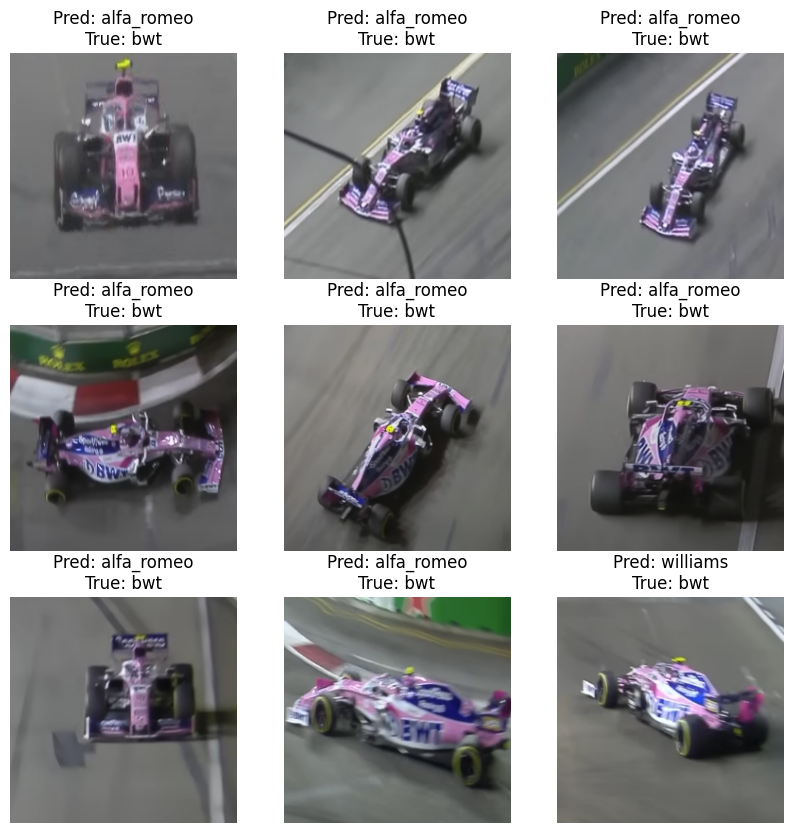

In [ ]:
# Print the accuracy and some predictions
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Display some example predictions
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(10):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        pred_class = predicted_class_indices[i]
        true_class = np.argmax(labels[i])
        plt.title(f"Pred: {test_class_names[pred_class]}\nTrue: {test_class_names[true_class]}")
        plt.axis("off")

plt.show()

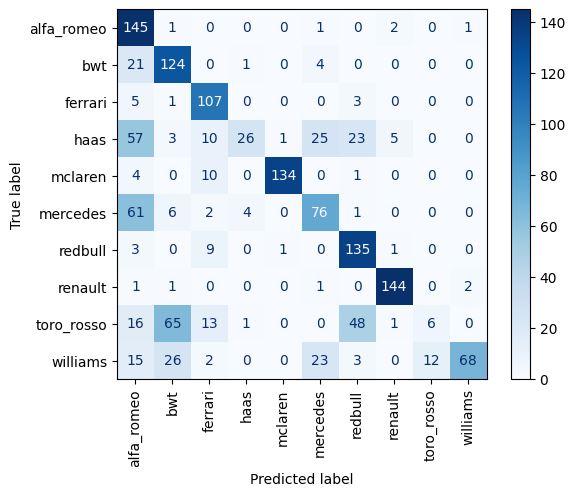

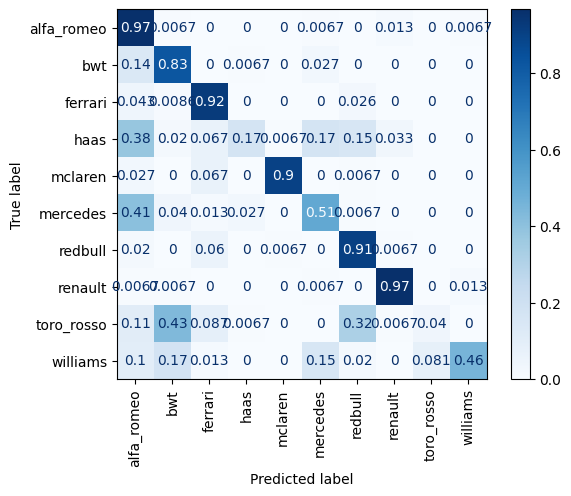

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)

# ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class_names)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.show()

# Normalize by the sum of each row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ConfusionMatrixDisplay with normalized values
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=test_class_names)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.show()


## Testing the model on photos from Autosport

In [ ]:
#Path to the test dataset
test_dir = '/content/drive/MyDrive/Colab Notebooks/DatasetClassification/f1cars/Autosport_Dataset'

# Load test data using image_dataset_from_directory, similar to train and validation data
test_data = keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",         # Labels are inferred from the directory structure
    label_mode="categorical",   # Same as in training
    color_mode="rgb",
    batch_size=32,
    image_size=(input_size[1], input_size[0]),
    shuffle=False              # No shuffling as this is for evaluation
)

test_class_names = test_data.class_names

Found 606 files belonging to 10 classes.


In [ ]:
# Prefetch the data to optimize performance
test_data = test_data.prefetch(tf.data.AUTOTUNE)

for layer in model.layers:
    if hasattr(layer, 'training'):
        layer.training = False

In [ ]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_data)

19/19 [==============================] - 9s 408ms/step - loss: 1.1600 - accuracy: 0.6502


In [ ]:
# Make predictions
predictions = model.predict(test_data)

# Convert predictions to class indices
predicted_class_indices = np.argmax(predictions, axis=1)

# Get true class labels from the test data
true_class_indices = np.argmax(np.concatenate([y for x, y in test_data], axis=0), axis=1)

19/19 [==============================] - 8s 407ms/step


Test Accuracy: 65.02%


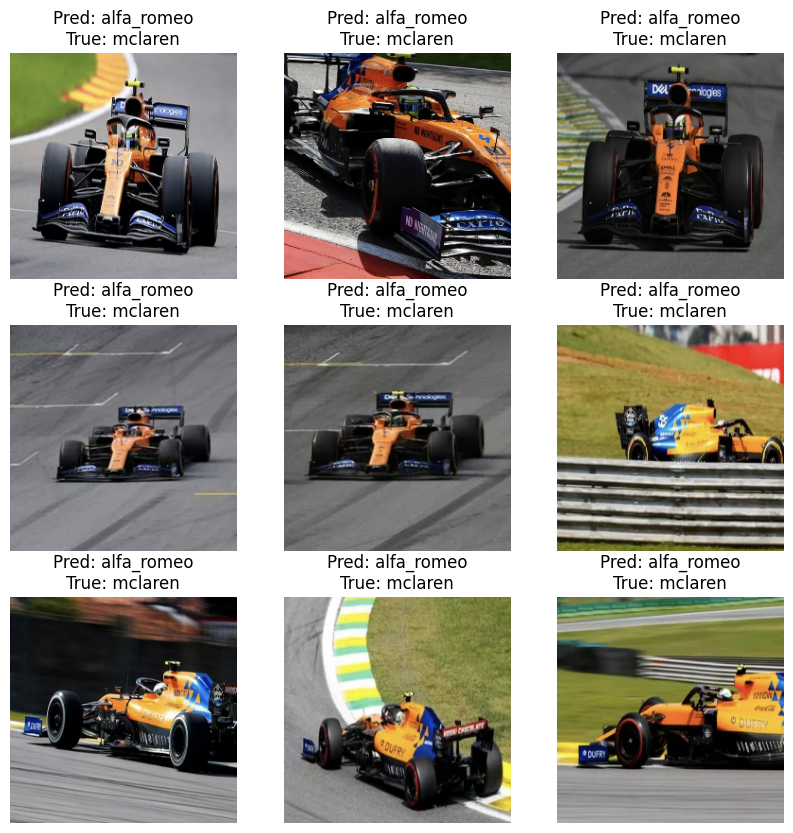

In [ ]:
# Print the accuracy and some predictions
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Display some example predictions
plt.figure(figsize=(10, 10))
for images, labels in test_data.take(10):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        pred_class = predicted_class_indices[i]
        true_class = np.argmax(labels[i])
        plt.title(f"Pred: {test_class_names[pred_class]}\nTrue: {test_class_names[true_class]}")
        plt.axis("off")

plt.show()

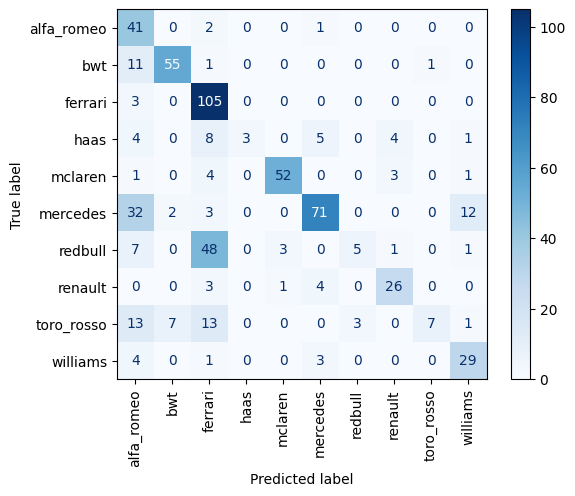

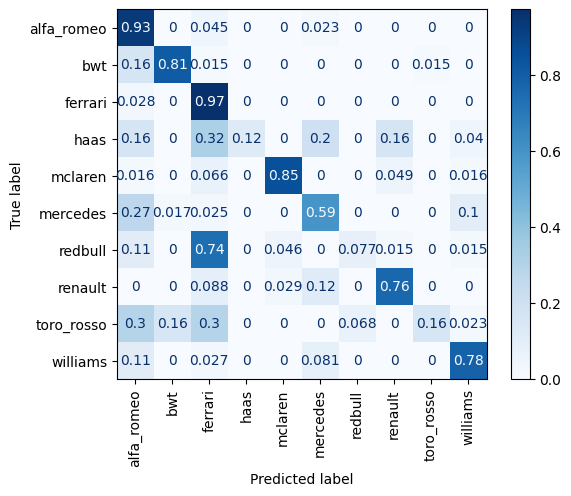

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)

# ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_class_names)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.show()

# Normalize by the sum of each row (true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# ConfusionMatrixDisplay with normalized values
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=test_class_names)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.show()
